In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import zipfile
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Dropout

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading The Images

In [ ]:
path = "/content/drive/MyDrive/OpenCV/Datasets/homer_bart_2.zip"
zip_object = zipfile.ZipFile(file = path , mode = "r")
zip_object.extractall("./")
zip_object.close()

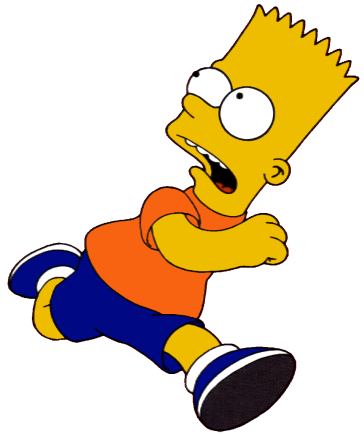

In [ ]:
load_img("/content/homer_bart_2/training_set/bart/bart100.bmp")

# Train And Test Set

In [ ]:
training_generator = ImageDataGenerator(rescale = 1./255,
                                        horizontal_flip = True,
                                        rotation_range = 7,
                                        zoom_range = 0.2)

train_dataset = training_generator.flow_from_directory("/content/homer_bart_2/training_set",
                                                    shuffle = True,
                                                    target_size = (256,256),
                                                    class_mode = "categorical",
                                                    batch_size = 8)

Found 215 images belonging to 2 classes.


In [ ]:
testing_generator = ImageDataGenerator(rescale = 1./255)

test_dataset = testing_generator.flow_from_directory("/content/homer_bart_2/test_set",
                                                      shuffle = False,
                                                      target_size = (256,256),
                                                      class_mode = "categorical",
                                                      batch_size = 1)

Found 215 images belonging to 2 classes.


In [ ]:
test_dataset.classes,test_dataset.class_indices

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 {'bart': 0, 'homer': 1})

# PreTrained Network

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

base_model = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256,256,3)))

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers:
    print(layer, layer.trainable)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
    print(layer, layer.trainable)

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# Custom Dense Layer

In [ ]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation="relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation = "softmax")(head_model)

In [ ]:
head_model

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_4')>

In [ ]:
head_model.summary()

# Building And Training The Neural Network

In [ ]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

model = Model(inputs = base_model.input, outputs = head_model )
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history = model.fit_generator(train_dataset, epochs = 50, validation_data = test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
27/27 [==============================] - 37s 679ms/step - loss: 1.2238 - accuracy: 0.5349 - val_loss: 0.6278 - val_accuracy: 0.6465
Epoch 2/50
27/27 [==============================] - 14s 510ms/step - loss: 0.7071 - accuracy: 0.5907 - val_loss: 0.6360 - val_accuracy: 0.6884
Epoch 3/50
27/27 [==============================] - 14s 509ms/step - loss: 0.6389 - accuracy: 0.6465 - val_loss: 0.5837 - val_accuracy: 0.6837
Epoch 4/50
27/27 [==============================] - 15s 568ms/step - loss: 0.6610 - accuracy: 0.6233 - val_loss: 0.5526 - val_accuracy: 0.7721
Epoch 5/50
27/27 [==============================] - 14s 528ms/step - loss: 0.5917 - accuracy: 0.6977 - val_loss: 0.5043 - val_accuracy: 0.7767
Epoch 6/50
27/27 [==============================] - 14s 528ms/step - loss: 0.6077 - accuracy: 0.6651 - val_loss: 0.4859 - val_accuracy: 0.7814
Epoch 7/50
27/27 [==============================] - 14s 534ms/step - loss: 0.6839 - accuracy: 0.5721 - val_loss: 0.5018 - val_accuracy: 0.8000

# Evaluating The Neural Network

In [ ]:
def history_graph(history, epochs):

    plt.figure(figsize = (10,6))

    plt.subplot(121)
    plt.plot(history.history["accuracy"],label = "Train")
    plt.plot(history.history["val_accuracy"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Accuracy Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.subplot(122)
    plt.plot(history.history["loss"],label = "Train")
    plt.plot(history.history["val_loss"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Loss Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.tight_layout()
    plt.show()

In [ ]:
def confusion_graph(y_test,y_pred):

    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize = (10,5))
    sns.heatmap(cm, annot = True, fmt = "d", cbar = False, linewidth = 0.4, linecolor="white", annot_kws = {"size" : 20})
    plt.ylabel("Actual",fontsize = 15)
    plt.xlabel("Predicted",fontsize = 15)
    plt.title("Confusion Matrix Graph", fontsize = 15)
    plt.show()

In [ ]:
model.evaluate(test_dataset)

215/215 [==============================] - 7s 31ms/step - loss: 0.2637 - accuracy: 0.9209


[0.2636776864528656, 0.9209302067756653]

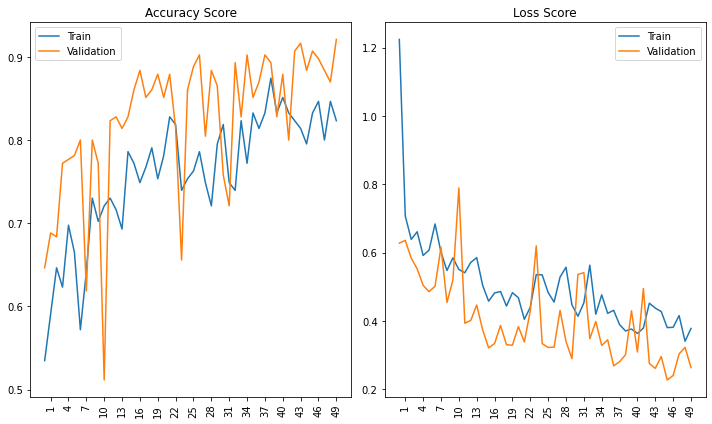

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history_graph(history, 50)

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

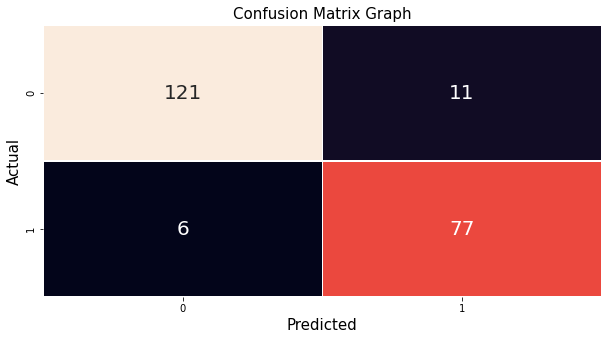

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns

confusion_graph(test_dataset.classes, y_pred)

In [ ]:
print(classification_report(test_dataset.classes,y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       132
           1       0.88      0.93      0.90        83

    accuracy                           0.92       215
   macro avg       0.91      0.92      0.92       215
weighted avg       0.92      0.92      0.92       215


Accuracy : 0.9209302325581395


# Fine Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers:
    print(layer, layer.trainable)

In [ ]:
len(base_model.layers)

175

In [ ]:
fine_tuning_at = 140

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

In [ ]:
# Model Değişiyor !!!! 

for layer in model.layers:
    print(layer.trainable)

In [ ]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

fining_history = model.fit(train_dataset, epochs = 50, validation_data = test_dataset)


Epoch 1/50
27/27 [==============================] - 28s 664ms/step - loss: 3.5867 - accuracy: 0.5721 - val_loss: 44.0695 - val_accuracy: 0.6140
Epoch 2/50
27/27 [==============================] - 14s 536ms/step - loss: 0.8899 - accuracy: 0.4605 - val_loss: 4.7912 - val_accuracy: 0.6140
Epoch 3/50
27/27 [==============================] - 14s 517ms/step - loss: 0.6813 - accuracy: 0.6047 - val_loss: 1.1264 - val_accuracy: 0.6140
Epoch 4/50
27/27 [==============================] - 14s 530ms/step - loss: 0.6944 - accuracy: 0.5953 - val_loss: 0.7872 - val_accuracy: 0.3860
Epoch 5/50
27/27 [==============================] - 14s 520ms/step - loss: 0.6854 - accuracy: 0.5767 - val_loss: 0.6936 - val_accuracy: 0.6140
Epoch 6/50
27/27 [==============================] - 14s 536ms/step - loss: 0.6743 - accuracy: 0.6093 - val_loss: 0.8064 - val_accuracy: 0.6140
Epoch 7/50
27/27 [==============================] - 13s 498ms/step - loss: 0.6606 - accuracy: 0.6140 - val_loss: 0.6243 - val_accuracy: 0.637

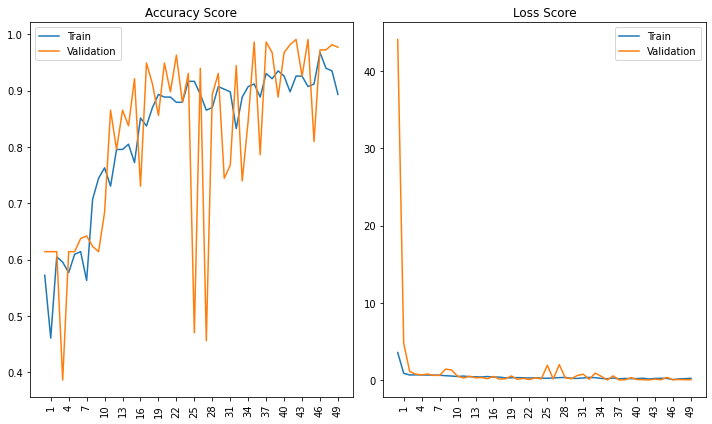

In [ ]:
history_graph(fining_history,50)

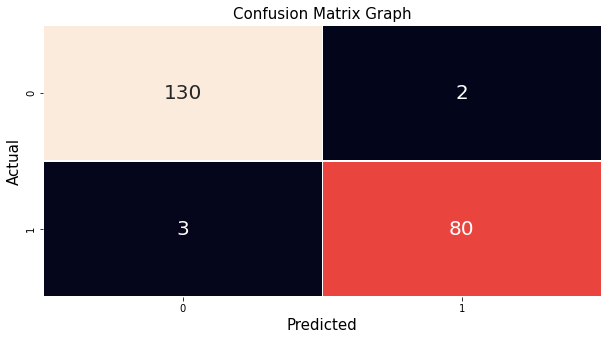

In [ ]:
fining_y_pred = model.predict(test_dataset)
fining_y_pred = np.argmax(fining_y_pred,axis = 1)
fining_y_pred[:10]

confusion_graph(test_dataset.classes, fining_y_pred)

In [ ]:
print(classification_report(test_dataset.classes,fining_y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,fining_y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       132
           1       0.98      0.96      0.97        83

    accuracy                           0.98       215
   macro avg       0.98      0.97      0.98       215
weighted avg       0.98      0.98      0.98       215


Accuracy : 0.9767441860465116


In [ ]:
# [0.2636776864528656, 0.9209302067756653] tuning yapmadan
# Arttı baya !!!

model.evaluate(test_dataset)

215/215 [==============================] - 7s 32ms/step - loss: 0.0687 - accuracy: 0.9767


[0.06866034120321274, 0.9767441749572754]

# Saving Loading and Classifying One Single Image

In [ ]:
model_json = model.to_json()
with open("model.json","w") as file:
    file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from tensorflow.keras.models import model_from_json,save_model

In [ ]:
save_model(model,"model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
with open("model.json","r") as file:
    load_model_json = file.read()

load_model_json

'{"class_name": "Functional", "config": {"name": "model_2", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regulariz

In [ ]:
load_model = model_from_json(load_model_json)
load_model.load_weights("/content/model.h5")
load_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
load_model.summary()

In [ ]:
import cv2
path = "/content/homer_bart_2/test_set/homer/homer15.bmp"
image = cv2.imread(path)
image = cv2.resize(image, (256,256))
image = image /255
image = image.reshape(1,256,256,3)
results = load_model.predict(image)
results = np.argmax(results)

if results == 0:
    print("Bart")
else:
    print("Homer")

Homer


----

# HomeWork

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/OpenCV/Datasets/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,GlobalAveragePooling2D

In [ ]:
training_generator = ImageDataGenerator(rescale = 1 / 255,
                                        horizontal_flip = True,
                                        rotation_range = 7,
                                        zoom_range = 0.2)

train_dataset = training_generator.flow_from_directory("/content/cat_dog_2/training_set",
                                                       target_size=(128,128),
                                                       shuffle = True,
                                                       class_mode = "binary",
                                                       batch_size = 128)

Found 4000 images belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale = 1 / 255)

test_dataset = test_generator.flow_from_directory("/content/cat_dog_2/test_set",
                                                  shuffle = False,
                                                  class_mode = "binary",
                                                  batch_size = 1,
                                                  target_size = (128,128))

Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights = "imagenet",include_top = False, input_shape = (128,128,3))
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 641, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 641, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1, activation = "sigmoid")(head_model)

In [ ]:
head_model

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [ ]:
model = Model(inputs = base_model.input , outputs = head_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

history = model.fit_generator(train_dataset, epochs = 5 ,validation_data = test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
32/32 [==============================] - 126s 4s/step - loss: 0.3025 - accuracy: 0.8850 - val_loss: 0.0956 - val_accuracy: 0.9640
Epoch 2/5
32/32 [==============================] - 109s 3s/step - loss: 0.1004 - accuracy: 0.9572 - val_loss: 0.0940 - val_accuracy: 0.9620
Epoch 3/5
32/32 [==============================] - 109s 3s/step - loss: 0.0937 - accuracy: 0.9615 - val_loss: 0.0871 - val_accuracy: 0.9640
Epoch 4/5
32/32 [==============================] - 78s 2s/step - loss: 0.0824 - accuracy: 0.9660 - val_loss: 0.0988 - val_accuracy: 0.9670
Epoch 5/5
32/32 [==============================] - 79s 2s/step - loss: 0.0738 - accuracy: 0.9710 - val_loss: 0.1010 - val_accuracy: 0.9640


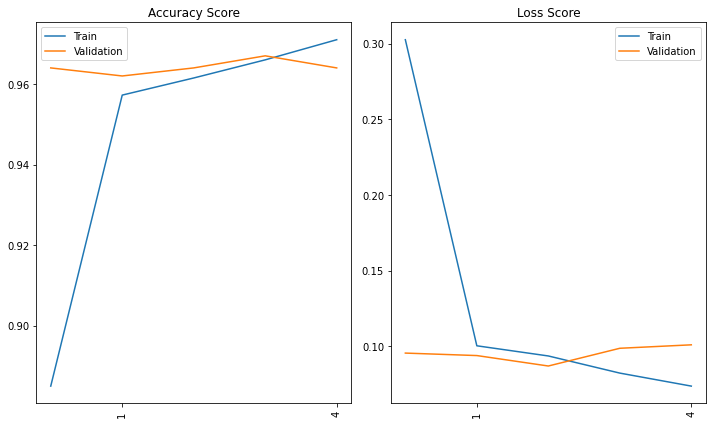

In [ ]:
history_graph(history, 5)

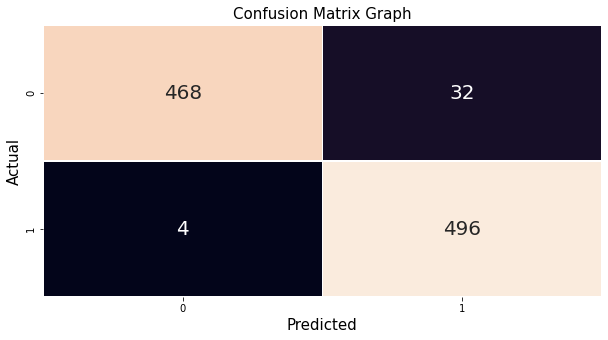

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5)

confusion_graph(test_dataset.classes,  y_pred)

In [ ]:
print(classification_report(test_dataset.classes, y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,  y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       500
           1       0.94      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000


Accuracy : 0.964


In [ ]:
model.evaluate(test_dataset)

1000/1000 [==============================] - 23s 23ms/step - loss: 0.1010 - accuracy: 0.9640


[0.10104382783174515, 0.9639999866485596]

# Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.layers)

154

In [ ]:
fine_tuning_at = 100

for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe0aadfd490> False
<keras.layers.convolutional.Conv2D object at 0x7fe00420a250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe004254410> False
<keras.layers.advanced_activations.ReLU object at 0x7fe006ab1f10> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fe00d00bfd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe005934c10> False
<keras.layers.advanced_activations.ReLU object at 0x7fe0058e0ad0> False
<keras.layers.convolutional.Conv2D object at 0x7fe0058d8d10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0058c6110> False
<keras.layers.convolutional.Conv2D object at 0x7fe0058ee7d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe00421e150> False
<keras.layers.advanced_activations.ReLU object at 0x7fe0058f4250> False
<keras.layers.convolutional.ZeroPadding2D 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
32/32 [==============================] - 149s 4s/step - loss: 0.1939 - accuracy: 0.9245 - val_loss: 1.0613 - val_accuracy: 0.9130
Epoch 2/5
32/32 [==============================] - 120s 4s/step - loss: 0.0888 - accuracy: 0.9700 - val_loss: 2.7283 - val_accuracy: 0.8370
Epoch 3/5
32/32 [==============================] - 124s 4s/step - loss: 0.0619 - accuracy: 0.9783 - val_loss: 5.7843 - val_accuracy: 0.7320
Epoch 4/5
32/32 [==============================] - 123s 4s/step - loss: 0.0640 - accuracy: 0.9753 - val_loss: 14.7074 - val_accuracy: 0.5340
Epoch 5/5
32/32 [==============================] - 122s 4s/step - loss: 0.0623 - accuracy: 0.9775 - val_loss: 5.5849 - val_accuracy: 0.8140


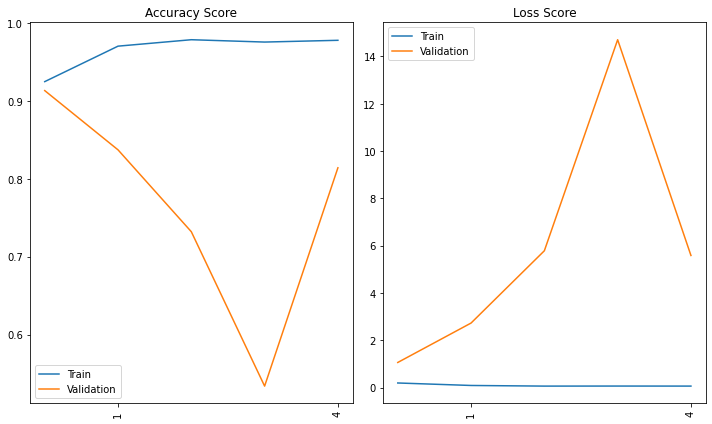

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])

fining_history = model.fit_generator(train_dataset, epochs = 5 ,validation_data = test_dataset)

history_graph(fining_history,5)

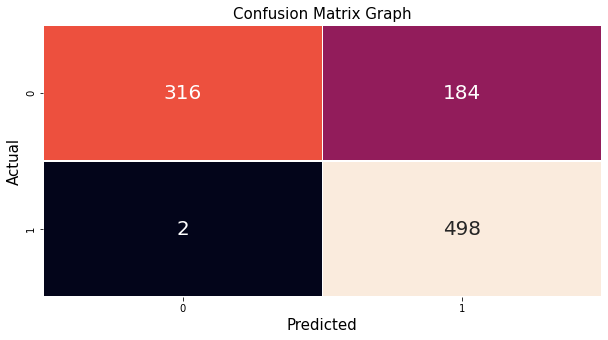

In [ ]:
fining_y_pred = model.predict(test_dataset)
fining_y_pred = (fining_y_pred > 0.5)

confusion_graph(test_dataset.classes, fining_y_pred)

In [ ]:
print(classification_report(test_dataset.classes, fining_y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,  fining_y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77       500
           1       0.73      1.00      0.84       500

    accuracy                           0.81      1000
   macro avg       0.86      0.81      0.81      1000
weighted avg       0.86      0.81      0.81      1000


Accuracy : 0.814


In [ ]:
# [0.10104382783174515, 0.9639999866485596] Fine Tuning öncesi

model.evaluate(test_dataset)

1000/1000 [==============================] - 22s 22ms/step - loss: 5.5849 - accuracy: 0.8140


[5.584943771362305, 0.8140000104904175]